In [112]:
print('hello world')

hello world


In [114]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

/home/s94zalek/shape_matching


In [115]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result
train_set = train_loader.dataset

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240425_163426


Calculating functional maps: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 97.69it/s]
/home/s94zalek/.conda/envs/fmnet/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Calculating functional maps: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 98.51it/s]


In [117]:
from utils.geometry_util import get_all_operators, to_basis, from_basis, compute_hks_autoscale, compute_wks_autoscale, data_augmentation

data_x = train_set[0]['first']

wks_x = compute_wks_autoscale(
    evals=data_x['evals'].unsqueeze(0),
    evecs=data_x['evecs'].unsqueeze(0),
    mass=data_x['mass'].unsqueeze(0)
    )
wks_x

tensor([[[0.2950, 0.3332, 0.3782,  ..., 0.5814, 0.5980, 0.6176],
         [0.2955, 0.3338, 0.3788,  ..., 0.5711, 0.5878, 0.6079],
         [0.2710, 0.3052, 0.3456,  ..., 0.5182, 0.5411, 0.5654],
         ...,
         [0.0609, 0.0689, 0.0776,  ..., 0.6495, 0.6467, 0.6465],
         [0.0721, 0.0840, 0.0974,  ..., 0.6578, 0.6495, 0.6431],
         [0.0704, 0.0821, 0.0952,  ..., 0.6651, 0.6636, 0.6643]]])

In [118]:
wks_x.shape

torch.Size([1, 4999, 128])

In [119]:
import trimesh

def plot_wks_evecs(data_to_plot, wks_to_plot, evecs_indices, scene):
    
    scene.geometry.clear()
    
    # concat all eigenvectors of interest
    evecs_concat = torch.tensor([])
    for i in evecs_indices:
        evecs = wks_to_plot[:, i]
        evecs_concat = torch.cat((evecs_concat, evecs), 0)
        
    # make a color map with min/max values consistent for all shapes        
    cmap = trimesh.visual.color.interpolate(evecs_concat, 'bwr')

    # plot the meshes
    curr_vert = 0
    for i, _ in enumerate(evecs_indices):
        mesh = trimesh.Trimesh(
            vertices=data_to_plot['verts'].cpu().numpy() + np.array([i * 1, 0, 0]),
            faces=data_to_plot['faces'].cpu().numpy()
            )

        mesh.visual.vertex_colors = cmap[curr_vert:curr_vert + len(mesh.vertices)]
        curr_vert += len(mesh.vertices)
        scene.add_geometry(mesh)
        
scene = trimesh.Scene()

In [123]:
wks_x[0].shape

torch.Size([4999, 128])

In [147]:
plot_wks_evecs(
    data_to_plot=train_set[0]['first'],
    wks_to_plot=wks_x[0],
    evecs_indices=range(50, 70, 5),
    scene=scene
    )
scene.show()

In [146]:
wks_y = compute_wks_autoscale(
    evals=train_set[17 * 81]['first']['evals'].unsqueeze(0),
    evecs=train_set[17 * 81]['first']['evecs'].unsqueeze(0),
    mass=train_set[17 * 81]['first']['mass'].unsqueeze(0)
    )

plot_wks_evecs(
    data_to_plot=train_set[17 * 81]['first'],
    wks_to_plot=wks_y[0],
    evecs_indices=range(50, 70, 5),
    scene=scene
    )
scene.show()

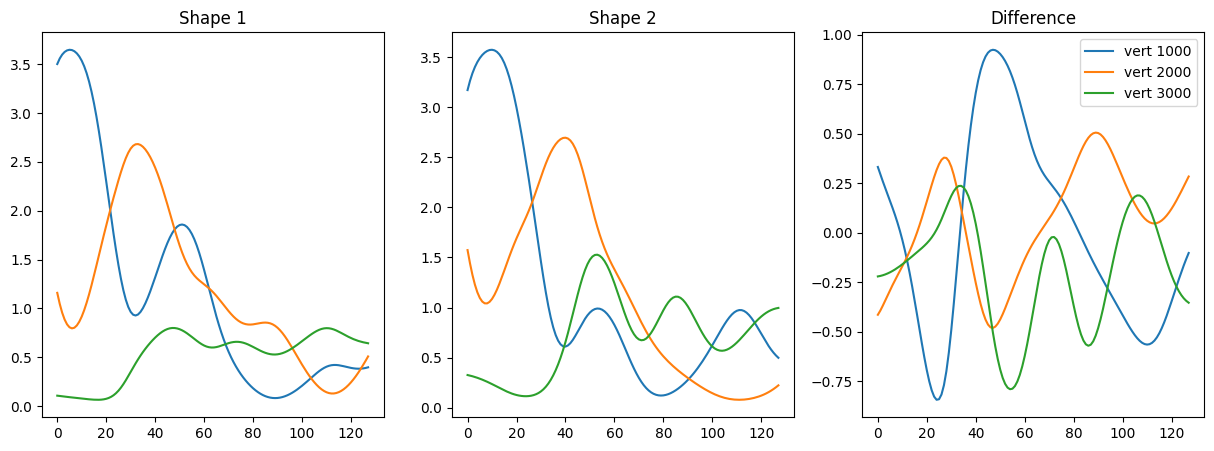

In [151]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(wks_x[0, 1000, :], label='vert 1000')
ax[0].plot(wks_x[0, 2000, :], label='vert 2000')
ax[0].plot(wks_x[0, 3000, :], label='vert 3000')
ax[0].set_title('Shape 1')

ax[1].plot(wks_y[0, 1000, :], label='vert 1000')
ax[1].plot(wks_y[0, 2000, :], label='vert 2000')
ax[1].plot(wks_y[0, 3000, :], label='vert 3000')
ax[1].set_title('Shape 2')

# plot difference
ax[2].plot(wks_x[0, 1000, :] - wks_y[0, 1000, :], label='vert 1000')
ax[2].plot(wks_x[0, 2000, :] - wks_y[0, 2000, :], label='vert 2000')
ax[2].plot(wks_x[0, 3000, :] - wks_y[0, 3000, :], label='vert 3000')
ax[2].set_title('Difference')

plt.legend()
plt.show()

In [156]:
wks_wks_T = wks_x[0].T @ wks_x[0]
wks_wks_T.shape

torch.Size([128, 128])

In [159]:
wks_x[0] @ wks_x[0].T

tensor([[184.7130, 184.1773, 171.9118,  ...,  69.7140,  80.3104,  76.4605],
        [184.1773, 183.6998, 170.7500,  ...,  68.8775,  79.1665,  75.4502],
        [171.9118, 170.7500, 168.4584,  ...,  71.3976,  85.1613,  79.6764],
        ...,
        [ 69.7140,  68.8775,  71.3976,  ...,  89.6176,  83.8678,  91.1006],
        [ 80.3104,  79.1665,  85.1613,  ...,  83.8678,  87.9384,  91.7798],
        [ 76.4605,  75.4502,  79.6764,  ...,  91.1006,  91.7798,  98.4909]])

In [158]:
wks_x[0].T @ wks_x[0]

tensor([[12968.2393, 13056.4307, 13114.0459,  ..., 11971.7529, 11982.1670,
         11969.0420],
        [13056.4307, 13160.8350, 13231.8770,  ..., 12122.4229, 12130.4248,
         12114.1992],
        [13114.0459, 13231.8770, 13314.1670,  ..., 12238.0176, 12244.0615,
         12225.3672],
        ...,
        [11971.7529, 12122.4229, 12238.0176,  ..., 23453.8281, 23463.3828,
         23413.2656],
        [11982.1670, 12130.4248, 12244.0615,  ..., 23463.3828, 23487.8398,
         23453.4648],
        [11969.0420, 12114.1992, 12225.3672,  ..., 23413.2656, 23453.4648,
         23435.9609]])